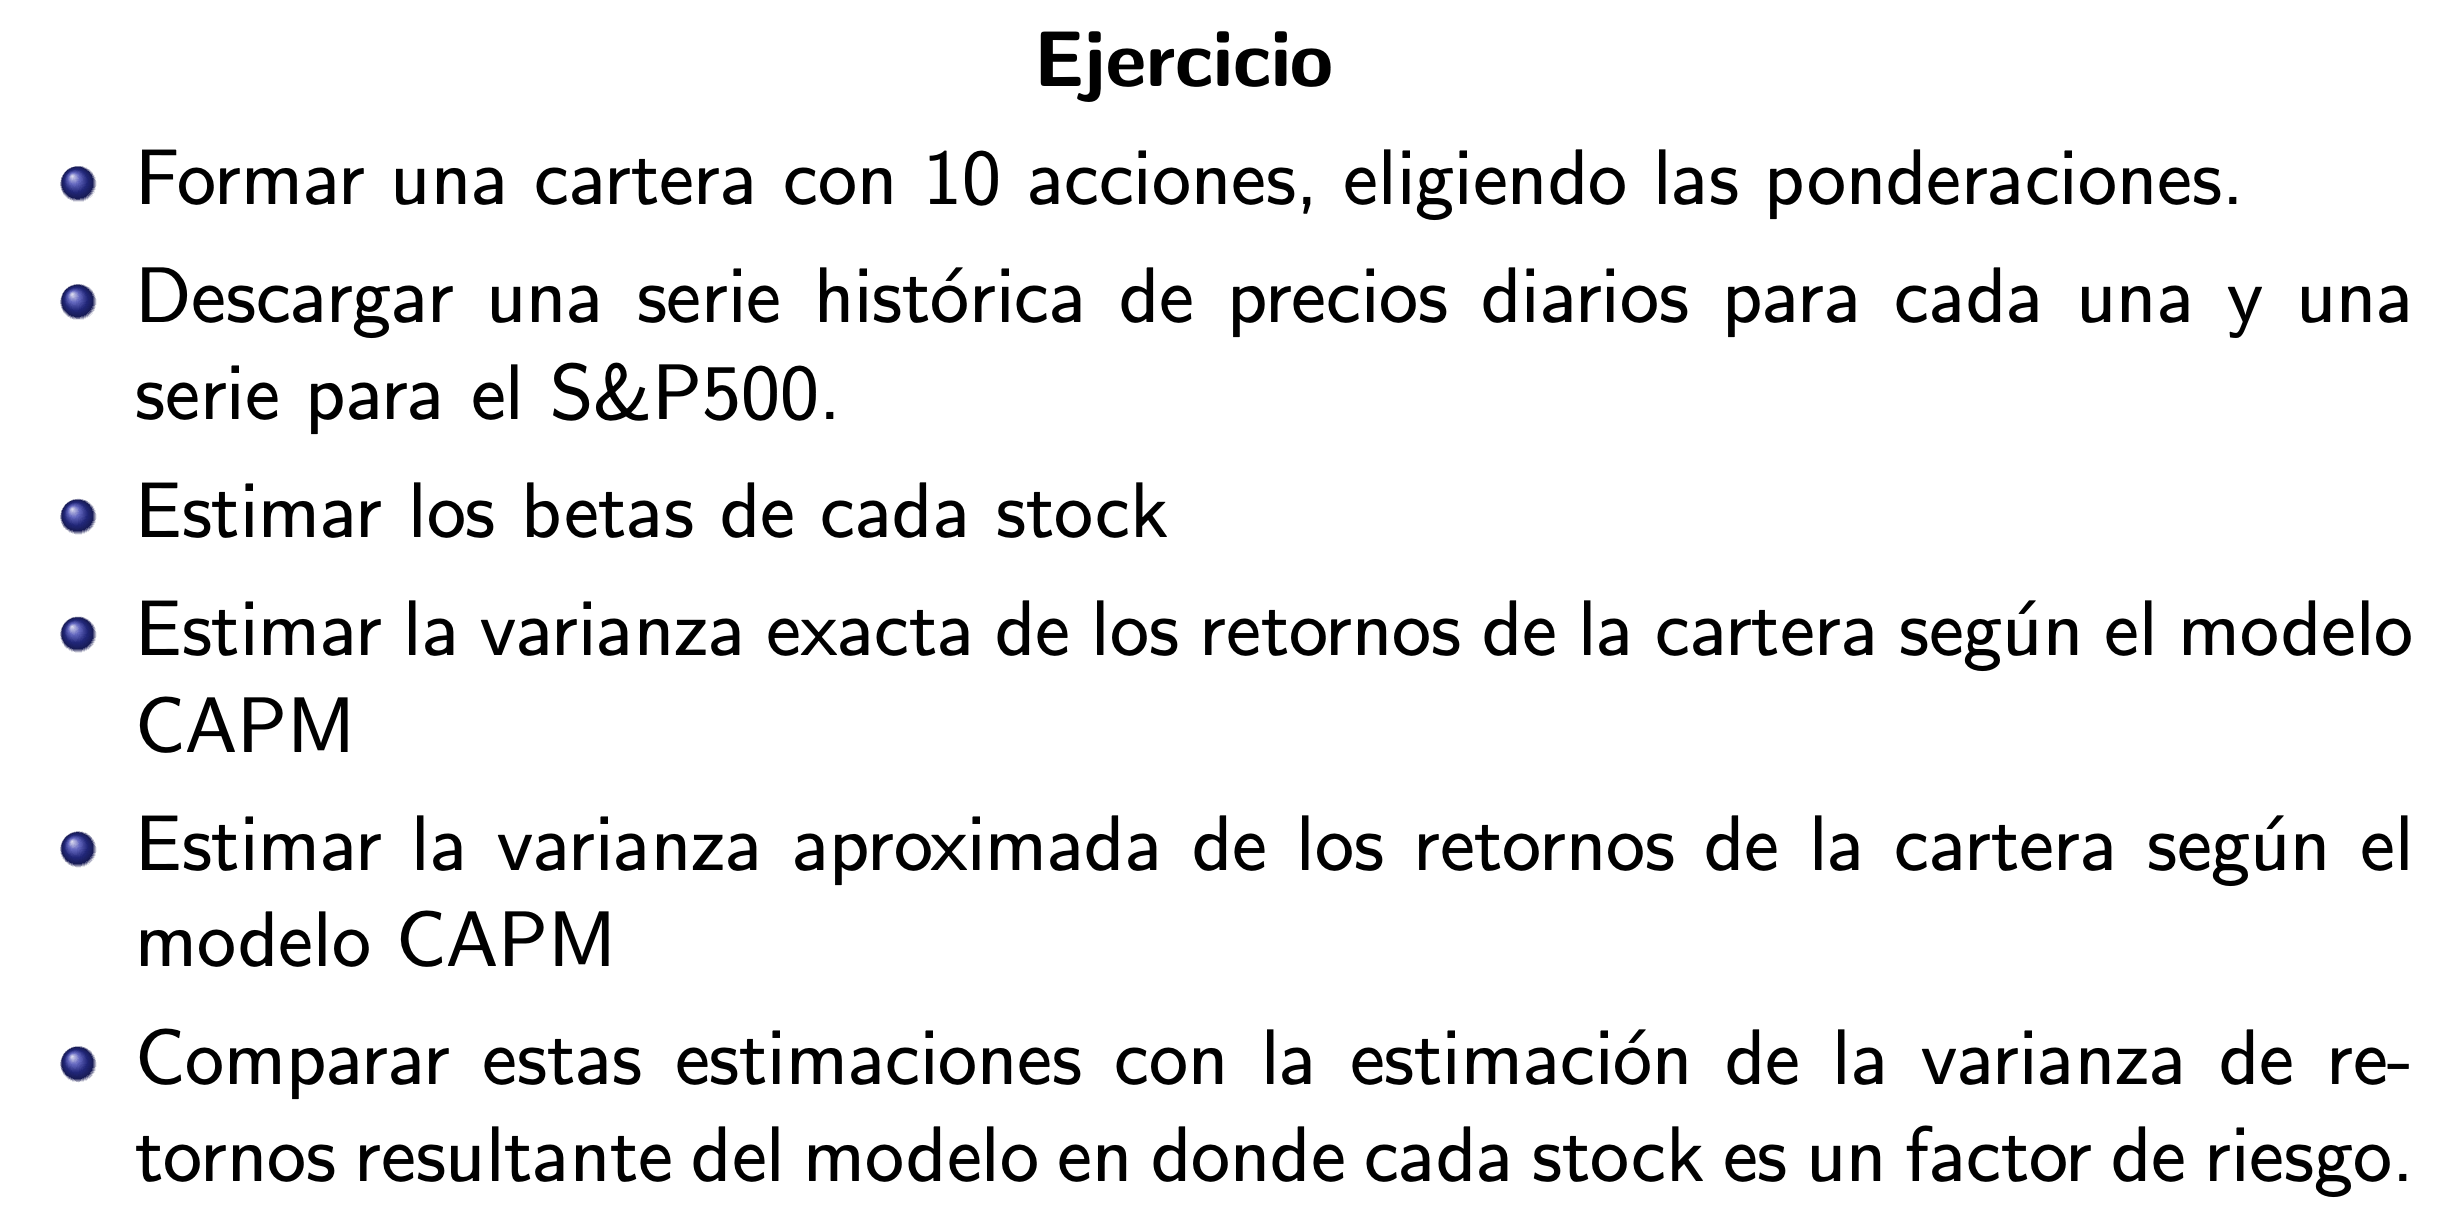

In [1]:
# imports 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import datetime as dt
import random
import statsmodels.api as sm

from scipy.stats import norm
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

import yfinance as yf
from pypfopt.efficient_frontier import EfficientFrontier
from pypfopt import risk_models
from pypfopt import expected_returns

#### 1. Getting S&P500 tickers lists for wiki and getting historical returns of 10 random stocks

In [2]:
# wiki page
url = 'https://en.wikipedia.org/wiki/List_of_S%26P_500_companies'

# get list of tickers
sp500_tickers = pd.read_html(url, skiprows=0)

# where are two table in that page, we need only the first one
sp500_tickers = sp500_tickers[0]

# tickers list
tickers_list = sp500_tickers.Symbol.values.tolist()

In [3]:
# get 10 random tickers
tickers = random.sample(tickers_list,10)
print(tickers)

['XEL', 'VRSN', 'DVN', 'RCL', 'TMUS', 'ISRG', 'CZR', 'WST', 'REGN', 'MLM']


In [4]:
ticker_str = ''
# iterating through the tickers list
for i,v in enumerate(tickers):
    # sum all value into a string
    ticker_str = ticker_str + ' ' +  v
    
print(ticker_str)    

 XEL VRSN DVN RCL TMUS ISRG CZR WST REGN MLM


In [5]:
# get stocks historic data
data = yf.download(
    tickers = ticker_str, 
    #period = '1Y',
    start='2015-01-01',
    end = dt.datetime.now(),
    interval = '1d')['Adj Close'].dropna()

data.columns
data.head(3)

[*********************100%***********************]  10 of 10 completed


,CZR,DVN,ISRG,MLM,RCL,REGN,TMUS,VRSN,WST,XEL
Date,,,,,,,,,,
2015-01-02,4.04,52.517902,175.190002,104.546440,73.958031,410.160004,27.299999,57.189999,50.278553,29.513472
2015-01-05,4.25,50.570896,171.456665,100.283463,72.852448,412.470001,26.930000,56.240002,49.584526,29.178459
2015-01-06,4.07,49.537071,173.263336,99.321449,73.066429,396.890015,26.870001,55.180000,48.736263,29.333715


In [6]:
# get stock's historic data
sp500 = yf.download(
    tickers = '^GSPC', 
    #period = '1Y',
    start='2015-01-01',
    end = dt.datetime.now(),
    interval = '1d')['Adj Close'].dropna()

sp500.head(3)

[*********************100%***********************]  1 of 1 completed


Date
2015-01-02    2058.199951
2015-01-05    2020.579956
2015-01-06    2002.609985
Name: Adj Close, dtype: float64

#### 2. Calculating weights for achiving highest Sharpe-Ratio

In [7]:
# Annualized mean  returns
mu = expected_returns.mean_historical_return(data, compounding=False) 
print(mu)
# annualized covariance
cov_matrix = risk_models.sample_cov(data)
print(cov_matrix)
# daily returns covarinance matrix
daily_cov_matrix = cov_matrix / 252
print(daily_cov_matrix)

CZR     0.668811
DVN     0.063606
ISRG    0.307789
MLM     0.255130
RCL     0.153735
REGN    0.121273
TMUS    0.291137
VRSN    0.230248
WST     0.360662
XEL     0.151836
dtype: float64
           CZR       DVN      ISRG       MLM       RCL      REGN      TMUS  \
CZR   0.390221  0.141187  0.071128  0.082164  0.193009  0.023009  0.055998   
DVN   0.141187  0.312709  0.050097  0.078473  0.134030  0.026942  0.043613   
ISRG  0.071128  0.050097  0.087288  0.036686  0.061383  0.033210  0.031432   
MLM   0.082164  0.078473  0.036686  0.115649  0.079388  0.024367  0.029401   
RCL   0.193009  0.134030  0.061383  0.079388  0.285533  0.020120  0.043393   
REGN  0.023009  0.026942  0.033210  0.024367  0.020120  0.115942  0.032360   
TMUS  0.055998  0.043613  0.031432  0.029401  0.043393  0.032360  0.076897   
VRSN  0.046777  0.038559  0.040985  0.027893  0.035822  0.031558  0.029268   
WST   0.029928  0.023892  0.036025  0.019511  0.022866  0.034297  0.024504   
XEL   0.019221  0.010569  0.021753 

In [8]:
# calculating weights
from pypfopt import objective_functions

ef = EfficientFrontier(mu, cov_matrix)
      
ef.add_objective(objective_functions.L2_reg, gamma = 0.1)
w = ef.max_sharpe()

ef.portfolio_performance(verbose=1)

print(ef.clean_weights(rounding=3))

weights = list(ef.clean_weights(rounding=3).values())
weights = np.array(weights)

print(weights)

Expected annual return: 37.5%
Annual volatility: 23.5%
Sharpe Ratio: 1.51
OrderedDict([('CZR', 0.201), ('DVN', 0.0), ('ISRG', 0.122), ('MLM', 0.066), ('RCL', 0.0), ('REGN', 0.0), ('TMUS', 0.163), ('VRSN', 0.072), ('WST', 0.309), ('XEL', 0.067)])
[0.201 0.    0.122 0.066 0.    0.    0.163 0.072 0.309 0.067]


/usr/local/Caskroom/miniconda/base/envs/pyfinance-env/lib/python3.8/site-packages/pypfopt/efficient_frontier/efficient_frontier.py:252: UserWarning: max_sharpe transforms the optimization problem so additional objectives may not work as expected.
  warnings.warn(


#### 3,  Getting betas, portfolio variance and expected return

In [9]:
# get daily returns
returns = data.pct_change()[1:]
sp500_returns = sp500.pct_change()[1:]

betas = []
var_errors = []

for i in range(data.shape[1]):
    # assign variables
    y = returns.iloc[:,i].values.reshape(-1,1)
    X = sp500_returns.values.reshape(-1,1)
    X = sm.add_constant(X)
    
    model = sm.OLS(y,X)
    
    # fit the model
    res = model.fit()
    
    # estimate variance of resids
    var_resids = np.var(res.resid)
    
    
    # get beta
    beta = float(res.params[1])

    # save beta and mse into the lists
    betas.append(np.round(beta,2))
    var_errors.append(np.round(var_resids,6))
print(betas)
print(var_errors)

[1.75, 1.64, 1.12, 1.04, 1.56, 0.82, 0.87, 0.98, 0.77, 0.6]
[0.001146, 0.000886, 0.00018, 0.000316, 0.000814, 0.000371, 0.000206, 0.000144, 0.000194, 0.000135]


In [10]:
# change dtype for the list of betas to array
betas = np.array(betas)

# calculating beta of portfolio
beta_port = (weights * betas).sum()

# calculateing market variance
mkt_var = np.round(np.var(sp500_returns.values), 5)

# calculate aproximate and exact portfolio deviation
apx_port_var = beta_port**2 * mkt_var
port_var = apx_port_var + (var_errors * weights**2).sum()

# calculate variance with N risk factors
n_factor_var = weights.T.dot(daily_cov_matrix).dot(weights)

# save betas and weights into a dataframe
df = pd.DataFrame(list(zip(betas,weights)), columns=['Betas','weight'], index=data.columns)

In [11]:
print("      RESULTS")
print('='*20)
print(df)
print('\n')
print(ef.portfolio_performance(verbose=1))
print('\n')
print('Portfolio Beta: {}'.format(beta_port))
print('Aproximate portfolio variance: {}'.format(apx_port_var))
print('Exact portfolio variance: {}'.format(port_var))
print('N Risk Factors model variance: {}'.format(n_factor_var))

      RESULTS
      Betas  weight
CZR    1.75   0.201
DVN    1.64   0.000
ISRG   1.12   0.122
MLM    1.04   0.066
RCL    1.56   0.000
REGN   0.82   0.000
TMUS   0.87   0.163
VRSN   0.98   0.072
WST    0.77   0.309
XEL    0.60   0.067


Expected annual return: 37.5%
Annual volatility: 23.5%
Sharpe Ratio: 1.51
(0.3745682222889962, 0.2346313392078956, 1.511171625606374)


Portfolio Beta: 1.04753
Aproximate portfolio variance: 0.000142651483117
Exact portfolio variance: 0.00021835568411700002
N Risk Factors model variance: 0.00021832914318705495
